# Generating Conformers

A drug-like molecule can exist in a variety of diverse 3D shapes depending on the number of rotatable bonds, bond order, torsion, and in general, its degree of freedom. Each individual 3D spatial arrangement of a molecule is defined as ***conformer*** and each conformer may have  different properties (e.g. relative energy). This is why the [sampling of the conformational space](https://pubs.acs.org/doi/full/10.1021/acs.jcim.7b00221), often referred to as conformational search, is a key step to understand the 3D properties of a given compound. You must factor in all the possible conformers and their respective properties in order to achieve the best representation of a molecule. It is a necessary step in any [virtual screening](https://en.wikipedia.org/wiki/Virtual_screening#:~:text=Virtual%20screening%20(VS)%20is%20a,a%20protein%20receptor%20or%20enzyme.) campaign.

**Note:** You can see a good visualization on how relative energy of conformers changes based on manual manipulation of bond angles [here](https://www.sas.upenn.edu/~kimg/mcephome/chem502/ethbutconform/ethbutmm2.html#:~:text=The%20highest%20energy%20conformer%2C%20the,energy%20of%203.5803%20kcal%2F%20mol.). 

A common term that you will see throughout this example is ***RMSD*** which stands for root-mean-square deviation. RMSD is widely used as a similarity measure when analyzing conformations: the smaller the RMSD between two conformers, the more similar in 3D spatial arrangement they are. Once conformers are generated, they are usually pruned on RMSD, meaning, structures that are redundant and essentially correspond to the same conformation are removed from the list. 

**Note:** RMSD is not the only measure of conformer similarity, and it does have its limitations. If you’re interested in learning more about all the various ways in which chemical structural similarity can be measured, read more [here.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6068280/) 

### How are conformers generated?

The current default RDKit method used to generate conformers leverages various versions of experimental-torsion distance geometry with additional basic knowledge ([ETKDG](https://pubs.acs.org/doi/full/10.1021/acs.jcim.5b00654)) created by Riniker and Landrum. From the RDKit book the default algorithm followed is:

1. The molecule’s distance bounds matrix is calculated based on the connection table and a set of rules.
2. The bounds matrix is smoothed using a triangle-bounds smoothing algorithm.
3. A random distance matrix that satisfies the bound's matrix is generated.
4. This distance matrix is embedded in 3D dimensions (producing coordinates for each atom).
5. The resulting coordinates are cleaned up somewhat using the “distance geometry force field”, based on distance constraints from the bounds matrix. 

The first 5 steps describe the “ETDG” approach. The additional “K” in ETKDG just defines further constraints from chemical knowledge such as “aromatic rings are to be flat or bonds connected to triple bonds are to be collinear”. These additional constraints introduce a certain level of “chemical awareness” that helps generate correct conformers which are chemically and physically valid. Read more [here](https://www.blopig.com/blog/2016/06/advances-in-conformer-generation-etkdg-and-etdg/), [here](https://greglandrum.github.io/rdkit-blog/conformers/exploration/2021/01/31/looking-at-random-coordinate-embedding.html) and [here](https://greglandrum.github.io/rdkit-blog/conformers/exploration/2021/02/22/etkdg-and-distance-constraints.html). 

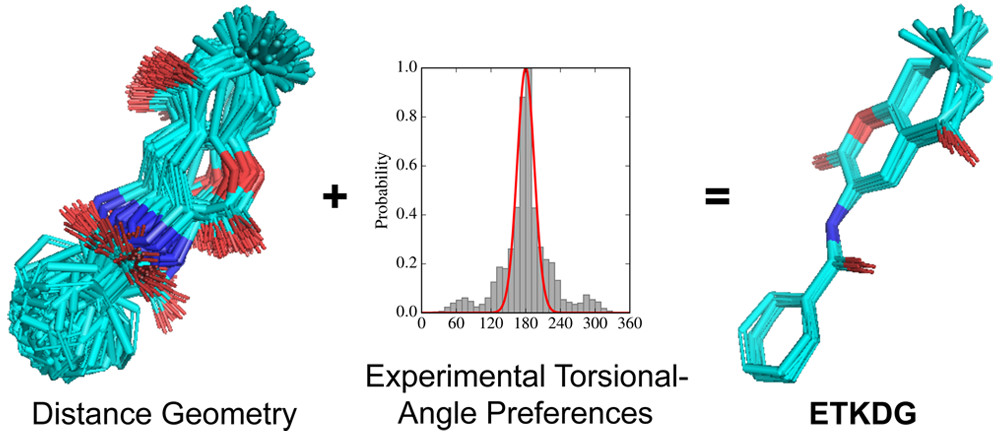

***[Source](https://pubs.acs.org/doi/10.1021/acs.jcim.5b00654)***

## Tutorial

Now let’s start with a tutorial on how you would go about generating conformers via RDKit.

## RDKit Example

Below is an example of how you would go about generating conformers in RDKit.

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDistGeom
from rdkit.Chem import rdMolAlign
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdMolTransforms
from rdkit.Chem import rdForceFieldHelpers

from rdkit.Chem import PyMol
import copy
import numpy as np

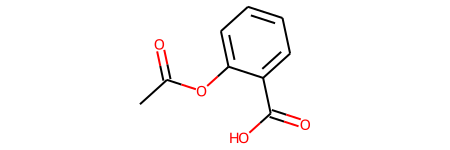

In [3]:
m = Chem.MolFromSmiles('O=C(C)Oc1ccccc1C(=O)O')
m

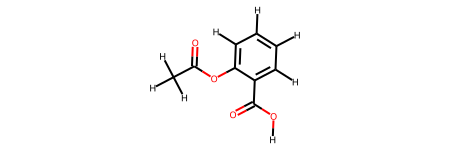

In [4]:
m2 = Chem.AddHs(m)
m2

In [5]:
AllChem.EmbedMolecule(m2)

0

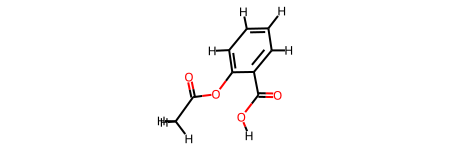

In [6]:
m2

In [7]:
rotatable_bonds = Chem.rdMolDescriptors.CalcNumRotatableBonds(m2)
rotatable_bonds

3

In [9]:
# Setup the parameters for the embedding
params = getattr(rdDistGeom, "ETDG")()
params.randomSeed = 0
params.enforceChirality = True
params.useRandomCoords = True
params.numThreads = 1

In [10]:
# EMbed conformers
confs = rdDistGeom.EmbedMultipleConfs(m2, numConfs=50, params=params)

In [11]:
len(confs)

50

In [12]:
#Minimize energy
energy_iterations = 200
results = rdForceFieldHelpers.UFFOptimizeMoleculeConfs(m2, maxIters=energy_iterations)
energies = [energy for _, energy in results]
energies = []
for conf in m2.GetConformers():
    ff = rdForceFieldHelpers.UFFGetMoleculeForceField(m2, confId=conf.GetId())
    energies.append(ff.CalcEnergy())
energies = np.array(energies)
# Add the energy as a property to each conformers
[
    conf.SetDoubleProp("rdkit_uff_energy", energy)
    for energy, conf in zip(energies, m2.GetConformers())
]

# Now we reorder conformers according to their energies,
# so the lowest energies conformers are first.
mol_clone = copy.deepcopy(m2)
ordered_conformers = [
    conf for _, conf in sorted(zip(energies, mol_clone.GetConformers()), key=lambda x: x[0])
]
m2.RemoveAllConformers()
[m2.AddConformer(conf, assignId=True) for conf in ordered_conformers]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49]

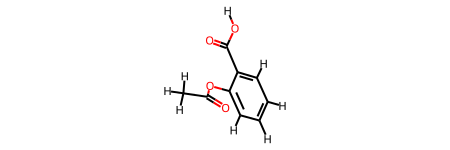

In [13]:
# Align conformers to each others
rdMolAlign.AlignMolConformers(m2)
m2

As a beginner, this can be a bit overwhelming and complicated to get the hang of. Let’s see how this would look in Datamol

## Datamol Example

In [15]:
%load_ext autoreload
%autoreload 2
import datamol as dm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


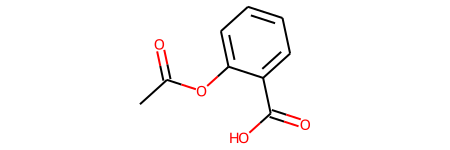

In [16]:
smiles = "O=C(C)Oc1ccccc1C(=O)O"
mol = dm.to_mol(smiles)
mol

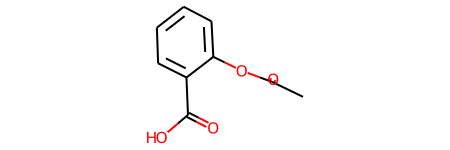

In [17]:
# generate conformers
mol = dm.conformers.generate(mol, align_conformers=True)
mol

In [18]:
# Get all conformers as a list
conformers = mol.GetConformers()

In [19]:
len(conformers)

50

In [20]:
# Get the 3D atom positions of the first conformer
positions = mol.GetConformer(0).GetPositions()
positions

array([[ 2.03942419, -1.45922972, -0.5317635 ],
       [ 1.99263631, -1.56446468,  0.71918407],
       [ 3.17475723, -2.13427287,  1.41002923],
       [ 0.83776239, -1.13909896,  1.35783965],
       [-0.24741278, -0.60913374,  0.65486606],
       [-0.31728327,  0.74698269,  0.41866521],
       [-1.37604602,  1.30106187, -0.27254643],
       [-2.40163014,  0.50559754, -0.74968685],
       [-2.35444025, -0.85475256, -0.52596736],
       [-1.27294042, -1.39641191,  0.17657748],
       [-1.21427441, -2.8252044 ,  0.4168274 ],
       [-0.25085537, -3.31954322,  1.04442977],
       [-2.22026164, -3.68264236, -0.04010149]])

In [21]:
# If minimization has been enabled (default to True)
# you can access the computed energy.
conf = mol.GetConformer(0)
props = conf.GetPropsAsDict()
print(props)

{'rdkit_uff_energy': 35.402383024447225}


In [22]:
# Compute RMSD
rmsd = dm.conformers.rmsd(mol)
rmsd

array([[0.00000000e+00, 1.01201288e+00, 3.80585511e-02, ...,
        1.00248204e+00, 6.38152829e-02, 9.30034182e-01],
       [1.01201288e+00, 4.67577303e-08, 1.01828888e+00, ...,
        7.17687634e-02, 1.01744973e+00, 4.35281059e-01],
       [3.80585511e-02, 1.01828888e+00, 4.67577303e-08, ...,
        1.01013936e+00, 7.97864852e-02, 9.43285047e-01],
       ...,
       [1.00248204e+00, 7.17687634e-02, 1.01013936e+00, ...,
        0.00000000e+00, 1.00439835e+00, 4.19279897e-01],
       [6.38152831e-02, 1.01744973e+00, 7.97864852e-02, ...,
        1.00439835e+00, 4.67577303e-08, 9.36046765e-01],
       [9.30034182e-01, 4.35281059e-01, 9.43285047e-01, ...,
        4.19279897e-01, 9.36046765e-01, 0.00000000e+00]])

In [23]:
rmsd.shape

(50, 50)

**In essentially one line of code, you can generate a list of conformers.** What’s important to understand are some of the key parameters that are factored into this process. In general, sticking with the defaults in Datamol will suffice in most cases, but if you want to make specific modifications, you can. If you’re interested in learning more about all the algorithms underlying conformer generation, read [this](https://pubs.acs.org/doi/10.1021/acs.jcim.7b00221). 

 A few parameters to highlight: 

- **n_confs** - Specifying the number of conformers to generate. This is based on the number of rotatable bonds and, by default, this is set to 200 if there are more than 8 rotatable bonds and 50 if there are less than 8. Theoretically, there are an unlimited number of conformers that can be derived from a single rotatable bond, however, in practice, not all the conformer structures make sense since only “stable” conformers are relevant in this context. This is why the defaults are set in place. Hypothetically, if you only have 2 rotatable bonds and you set n_confs to 2,000,000, not only will this be computationally expensive but a lot of the conformers generated will start to have non-relevant structures that are not useful.
- **add_hs** - By default, hydrogen atoms are added before embedding because it is critical to generating high quality 3D conformations.
- **minimize_energy** - Minimizing energy releases the strain of the generated conformation to the closest local minima enabling you to find a more relevant conformation. In other words, ***finding the conformer that is most likely to exist***. There are multiple force fields that you can apply.
- **method -**  Within the ETKDG method, there are various versions that can be selected to generate conformers.
- **energy_iterations -**  This options allows you to specify how many iterations of conformer generation you want to go through if you have enabled energy minimization. In general, the more iterations you specify, the more accurate the conformers. However, there is a trade off between the number of iterations and computation speed. Running through 1000 iterations will be significantly more expensive computationally as opposed to 100 iterations.
- **rms_cutoff** is the max RMSD value for which two conformers are considered to be the same.

The full table of parameters along with their definitions is shown below: